<a href="https://www.kaggle.com/code/pathompongmuangthong/my-very-dumb-logistic-regression-sklearn?scriptVersionId=118194487" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predict/Classification of user's rating given review text

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sb
import re

import warnings
warnings.filterwarnings("ignore")

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [2]:
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
%matplotlib inline

## Load The Dataset

In [3]:
df = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv',
                usecols=['review_text', 'rating'])

## Quick Lookup

In [4]:
df.head()

,rating,review_text
0,5,This is a special book. It started slow for ab...
1,3,Recommended by Don Katz. Avail for free in Dec...
2,3,"A fun, fast paced science fiction thriller. I ..."
3,0,Recommended reading to understand what is goin...
4,4,"I really enjoyed this book, and there is a lot..."


In [5]:
print(df['review_text'].apply(lambda x: len(x.split(' '))).sum())

176535573


<AxesSubplot:>

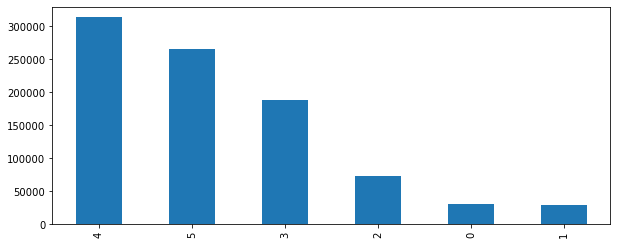

In [6]:
plt.figure(figsize=(10,4))
df.rating.value_counts().plot(kind='bar')

The rating label is imbalanced. <br/>
How can I handle this? hmm... <br/>
 - Using weighted RMSE loss?
 - Using scikit-learn's `LogisticRegression` class with weighting?

## Text Preprocessing

In [7]:
stopwords = stopwords.words('english')

In [8]:
def preprocess_desc(text_col):
    preprocessed_descs = []
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tag_pattern = re.compile('@(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    for sentence in tqdm(text_col.values):
        if sentence is np.nan:
            preprocessed_descs.append(sent.lower().strip())
            continue
        else:
            sent = url_pattern.sub('', sentence)
            sent = tag_pattern.sub('', sent)
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\"', ' ')
            sent = sent.replace('\\n', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
            preprocessed_descs.append(sent.lower().strip())
    return preprocessed_descs

In [9]:
df = df.assign(pre_text = preprocess_desc(df['review_text']))

100%|██████████| 900000/900000 [06:57<00:00, 2157.53it/s]


In [10]:
print(df['pre_text'].apply(lambda x: len(x.split(' '))).sum())

97059902


In [11]:
df.head()

,rating,review_text,pre_text
0,5,This is a special book. It started slow for ab...,this special book it started slow first third ...
1,3,Recommended by Don Katz. Avail for free in Dec...,recommended don katz avail free december
2,3,"A fun, fast paced science fiction thriller. I ...",a fun fast paced science fiction thriller i re...
3,0,Recommended reading to understand what is goin...,recommended reading understand going middle am...
4,4,"I really enjoyed this book, and there is a lot...",i really enjoyed book lot recommend it drag li...


## Train/Test Split

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['pre_text'], df['rating'], test_size=0.2, random_state=42)

## Text to Numerical Features using TF-IDF
Expand to read how `TfidfVectorizer` work

The `TfidfVectorizer` class in scikit-learn is a tool used to convert text data into numerical features that can be used as input to a machine learning model.

TF-IDF stands for term frequency-inverse document frequency. It's a measure of the importance of a word in a document with respect to an entire corpus of documents. The idea behind TF-IDF is to give more weight to words that are rare or specific to a particular document, and less weight to words that are common across all documents.

Here's how it works:

1. Term frequency (TF): The term frequency is the number of times a word appears in a document, normalized by the total number of words in the document. The resulting value is a measure of the importance of a word within a single document.

2. Inverse document frequency (IDF): The inverse document frequency is a measure of the rarity of a word across all documents in the corpus. It is calculated as the logarithm of the total number of documents divided by the number of documents containing the word.

3. TF-IDF: The final value for each word is obtained by multiplying its term frequency by its inverse document frequency. This results in a value that is high for words that are rare or specific to a particular document, and low for words that are common across all documents.

The `TfidfVectorizer` class implements this method by first tokenizing the text data into individual words (or "tokens"), and then computing the TF-IDF values for each token in each document. The result is a sparse matrix of features, where each row represents a document and each column represents a word.

The `TfidfVectorizer` class has built-in tokenization capabilities, so you can simply pass it the raw text data and it will handle the tokenization for you.

In [13]:
# Convert the text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [14]:
print(X_train_features.shape)
print(X_test_features.shape)
#print(vectorizer.vocabulary_)

(720000, 257103)
(180000, 257103)


## Train a Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
# Train a logistic regression model on the training data
#model = LogisticRegression()
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_features, y_train)

LogisticRegression(class_weight='balanced')

## Make Predictions

In [17]:
# Make predictions on the test data
y_pred = model.predict(X_test_features)

## Evaluate

In [18]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4757166666666667


This score is similar to submission score. <br/>
But going to submit it anyway :'>

## Predicts on unseen data

In [19]:
dfTest = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv',
                usecols=['review_id', 'review_text'])

In [20]:
dfTest.head()

,review_id,review_text
0,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...
1,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink..."
2,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...
3,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...
4,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...


In [21]:
dfTest = dfTest.assign(pre_text = preprocess_desc(dfTest['review_text']))

100%|██████████| 478033/478033 [03:44<00:00, 2125.78it/s]


In [22]:
dfTest

,review_id,review_text,pre_text
0,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...,spoiler alert this definitely one favorites am...
1,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink...",spoiler alert you drink i huge fan coffee i bu...
2,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...,roar one favorite characters under never sky i...
3,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...,spoiler alert if feel like travelling europe m...
4,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...,3 5 stars i read enjoyed first two novels seri...
...,...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,Can't wait for Travis' POV \n Travis Before Ab...,can wait travis pov travis before abby travis ...
478029,0b7f352e58caf0fd1f961e98ef04e89c,Had this on my to-read shelf forever. Will upd...,had read shelf forever will update i finished ...
478030,9b19eff33ddb14e9e68fca2e90379e46,The last book left me wanting for more. I need...,the last book left wanting i need happy ending...
478031,8be463fed78f0da63e964706f710332b,Things are heating up in the second novel of I...,things heating second novel infernal devices w...


In [23]:
unseen_features = vectorizer.transform(dfTest['pre_text'])

In [24]:
print(unseen_features.shape)

(478033, 257103)


In [25]:
# Use the model to make predictions on the new data
unseen_predictions = model.predict(unseen_features)

print("Predictions:", unseen_predictions)

Predictions: [4 4 0 ... 0 5 5]


In [26]:
# Create submission dataframe
submission = pd.DataFrame({'review_id': dfTest['review_id'],
                           'rating': unseen_predictions})

In [27]:
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,4
2,dce649b733c153ba5363a0413cac988f,0
3,8a46df0bb997269d6834f9437a4b0a77,3
4,d11d3091e22f1cf3cb865598de197599,4
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,0
478029,0b7f352e58caf0fd1f961e98ef04e89c,0
478030,9b19eff33ddb14e9e68fca2e90379e46,0
478031,8be463fed78f0da63e964706f710332b,5


In [28]:
# Export submission file for submit to competition
submission.to_csv("submission.csv", index=False)

## Lemme do it for you :'>
- Why training with `LogisticRegression` with ignoring about imbalanced data having better score :<
    - 0.52771 | `model = LogisticRegression()`
    - 0.47177 | `model = LogisticRegression(class_weight='balanced')` 

![Dog Zoiudo GIF](https://media.tenor.com/cbU3h2FqAGQAAAAd/dog-zoiudo.gif)

In [29]:
# Still need more learning :'<